#### установка зависимостей ...

In [17]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


##### https://pypi.org/project/apimoex/

In [18]:
pip install apimoex

Note: you may need to restart the kernel to use updated packages.


### Содержимое файла FinanceCode.py ...

In [1]:
import numpy as np
import pandas as pd
import requests
import plotly.graph_objects as go
import plotly.express as px
import datetime as dt
import os
from dateutil.relativedelta import relativedelta

&bullet; Если что-то не импортируется, попробуйте создать выше ячейку `pip install <что-то>` и выполнить.  
&bullet; Затем возвращайтесь сюда, к импортам.

In [2]:
import apimoex

In [3]:
import logging

In [35]:
class MoexAPI:
    ISS_URL = 'https://iss.moex.com/iss/'

    @staticmethod
    def download_history_data(ticker, timeframe, start, end, columns, market='shares', engine='stock'):
        with requests.Session() as session:
            try:
                data = apimoex.get_market_candles(session, ticker, timeframe, start, end,
                                                  columns, market, engine)
            except Exception as e:
                data = []
                logging.exception(e)
        return data

    @classmethod
    def query(cls, request_url: str, arguments=None):
        if arguments is None:
            arguments = {}
        with requests.Session() as session:
            try:
                iss = apimoex.ISSClient(session, cls.ISS_URL + request_url, arguments)
                response = iss.get()
            except Exception as e:
                data = []
                logging.exception(e)
        return response


class FinTimeSeries:

    STD_COLUMNS = ('begin', 'open', 'high', 'low', 'close', 'volume')

    def __init__(self, ticker, timeframe, start, end):
        data = MoexAPI.download_history_data(ticker, timeframe, start, end, self.STD_COLUMNS)
        self.data = pd.DataFrame(data)
        self.ticker = ticker
        self.timeframe = timeframe
        self.start = start
        self.end = end

    @classmethod
    def from_trade_days(cls, ticker, num_last_days, timeframe=24, curr_date=dt.date.today(), include_today=False):
        start = curr_date - relativedelta(days=num_last_days*2)
        if include_today:
            end = curr_date
        else:
            yesterday = curr_date - dt.timedelta(days=1)
            end = yesterday
        year_tm = cls(ticker, 24, str(start), str(end))
        year_tm.data = year_tm.data.tail(num_last_days)
        year_tm.data = year_tm.data.reset_index(drop=True)
        if timeframe != 24:
            start = year_tm.data['begin'].iloc[0]
            end = cls.add_delta(year_tm.data['begin'].iloc[-1], delta_duration=1, delta_mode='d')
            year_tm = cls(ticker, timeframe, start, end)
        return year_tm

    @classmethod
    def from_weeks(cls, ticker, num_weeks, timeframe=24, curr_date=dt.date.today()):
        start = curr_date - dt.timedelta(weeks=num_weeks)
        end = curr_date
        return cls(ticker, timeframe, start, end)

    @classmethod
    def from_months(cls, ticker, num_months, timeframe=24, curr_date=dt.date.today()):
        start = curr_date - relativedelta(months=num_months)
        end = curr_date
        return cls(ticker, timeframe, start, end)

    @classmethod
    def from_years(cls, ticker, num_years, timeframe=24, curr_date=dt.date.today()):
        start = curr_date - relativedelta(years=num_years)
        end = curr_date
        return cls(ticker, timeframe, start, end)

    @classmethod
    def from_last(cls, ticker, period_type, period_num, timeframe, curr_date=dt.date.today()):
        if period_type == 'd':
            return cls.from_trade_days(ticker, period_num, timeframe, curr_date)
        elif period_type == 'w':
            return cls.from_weeks(ticker, period_num, timeframe, curr_date)
        elif period_type == 'm':
            return cls.from_months(ticker, period_num, timeframe, curr_date)
        elif period_type == 'y':
            return cls.from_years(ticker, period_num, timeframe, curr_date)
        else:
            return cls.from_trade_days(ticker, period_num, timeframe, curr_date)

    def column(self, name):
        return self.data[name]

    def columns(self, column_names):
        return self.data[column_names]

    def candle_chart(self, without_slider=True):
        fig = go.Figure(data=[go.Candlestick(x=self.data['begin'],
                                             open=self.data['open'],
                                             high=self.data['high'],
                                             low=self.data['low'],
                                             close=self.data['close'])])
        if without_slider:
            fig.update_layout(xaxis_rangeslider_visible=False)
        fig.show()

    def line_chart(self, column='close', with_slider=False):
        fig = px.line(self.data, x='begin', y=column)
        if with_slider:
            fig.update_xaxes(rangeslider_visible=True)
        fig.show()

    def mean(self, column='close'):
        return self.data[column].mean()

    def var(self, column='close'):
        return self.data[column].var()

    def median(self, column='close'):
        return self.data[column].median()

    def std(self, column='close'):
        return self.data[column].std()

    def corr(self, columns=STD_COLUMNS):
        if len(columns) == 2:
            df_column1 = self.data[columns[0]]
            df_column2 = self.data[columns[1]]
            return df_column1.corr(df_column2)
        elif len(columns) > 2:
            df = self.data[list(columns)]
            return df.corr()
        else:
            return None

    def export_csv(self):
        project_dir = os.path.dirname(os.path.dirname(__file__))
        filename = "out_"+dt.datetime.now().strftime("%d.%m.%Y_%H.%M.%S")+'.csv'
        path = os.path.join(project_dir, 'data', 'export', filename)
        self.data.to_csv(path, index=False)
        return path

    def export_xlsx(self):
        project_dir = os.path.dirname(os.path.dirname(__file__))
        filename = "out_"+dt.datetime.now().strftime("%d.%m.%Y_%H.%M.%S")+'.xlsx'
        path = os.path.join(project_dir, 'data', 'export', filename)
        self.data.to_excel(path, index=False)
        return path

    def has_nulls(self):
        return self.nulls_count() > 0

    def nulls_count(self, by_columns=False):
        if by_columns:
            return dict(self.data.isna().sum())
        else:
            return self.data.isna().sum().sum()

    def fill_na(self, method='bfill'):
        self.data.fillna(method=method, inplace=True)

    def drop_na(self):
        self.data.dropna(inplace=True)

    def is_empty(self):
        return self.data.empty

    @staticmethod
    def add_delta(date: str, delta_duration, delta_mode='d', sub=False):
        if delta_mode == 'd':
            delta = dt.timedelta(days=delta_duration)
        elif delta_mode == 'w':
            delta = dt.timedelta(weeks=delta_duration)
        elif delta_mode == 'm':
            delta = relativedelta(months=delta_duration)
        elif delta_mode == 'y':
            delta = relativedelta(years=delta_duration)
        else:
            delta = dt.timedelta(days=delta_duration)
        dt_date = dt.date.fromisoformat(date.split(' ')[0])
        if not sub:
            date = dt_date + delta
        else:
            date = dt_date - delta
        return str(date)

    @staticmethod
    def transform_timeframe_for_api(timeframe):
        if timeframe == 'd':
            return 24
        elif timeframe == 'w':
            return 7
        elif timeframe == 'm':
            return 31
        elif timeframe == 'h':
            return 60
        elif timeframe == '10min':
            return 10
        elif timeframe == '1min':
            return 1
        else:
            return 24

    def __str__(self):
        return self.data.to_string()

    def __len__(self):
        return len(self.data['begin'])

In [32]:
ts = FinTimeSeries('SBER', 24, '2021.05.01', '2021.06.01')
    print(ts)

                  begin    open    high     low   close    volume
0   2021-05-04 00:00:00  298.70  304.23  298.20  303.70  60457530
1   2021-05-05 00:00:00  304.01  306.03  302.71  305.99  41715270
2   2021-05-06 00:00:00  306.29  314.98  306.25  314.72  62565270
3   2021-05-07 00:00:00  316.00  319.16  315.48  317.94  56433970
4   2021-05-10 00:00:00  318.26  320.19  314.31  320.19  59248110
5   2021-05-11 00:00:00  303.00  309.48  301.00  307.16  79945470
6   2021-05-12 00:00:00  307.39  309.24  302.00  302.02  56142830
7   2021-05-13 00:00:00  302.11  306.86  299.33  306.74  57721460
8   2021-05-14 00:00:00  308.20  308.24  302.33  304.10  26858430
9   2021-05-17 00:00:00  303.50  305.24  301.01  303.94  28384220
10  2021-05-18 00:00:00  305.01  306.62  303.33  305.78  35496400
11  2021-05-19 00:00:00  304.38  304.88  295.10  297.00  71747950
12  2021-05-20 00:00:00  297.94  298.37  293.00  296.72  58510610
13  2021-05-21 00:00:00  296.85  302.98  294.90  301.23  51415080
14  2021-0

In [33]:
# посмотрим, что получилось...

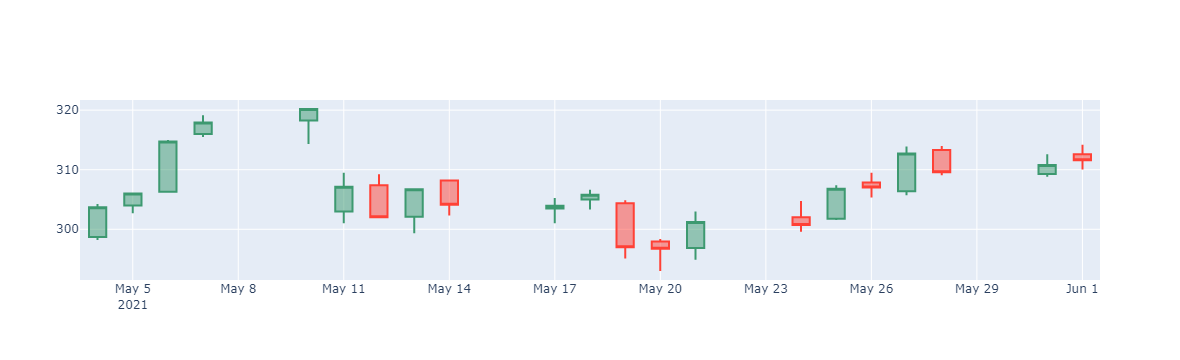

In [34]:
ts.candle_chart()